# Section 7:  Power Spectra Part 1 -  Harmonic Analysis using CAR maps [Naess et al, in preparation]

Now that users are able to import and examine data we present an introduction to harmonic analysis using the DR4 maps.  We will present an example of a simple ACT-Planck cross correlation usin the coadded maps first introduced in Notebook 2, but we also encourage users to consider cross correlations with other maps or galaxy density maps. 

We ask that when using the coadded map in this notebook you refer to  [Naess et al. 2020, in preparation].

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Section_1_Introduction.ipynb): Introduction to AdvACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps from [Naess et al. (2020)](https://www.overleaf.com/5395816498bsknshgxbmyr) and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf)

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al. (2020)](https://arxiv.org/abs/1911.05717)

> [Section 7](Section_7_power_spectra_part_1.ipynb): Power Spectra Part 1 -  Harmonic Analysis using CAR maps [Naess et al, in preparation]

> [Section 8](Section_8_power_spectra_part_2.ipynb): Power Spectra Part 2 - Individual Map splits and Nawrapper [Aiola et al] and [Choi et al] 

> [Section 9](Section_9_Noise_sims.ipynb): Generating Noise Simulations 

> [Section 10](Section_10_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps. 

> [Section 11](Section_11_ACT_likelihood.ipynb): Using the ACT Likelihood code
 
> [Section 12](Section_12_delensing_param_shifts.ipynb):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters from [Han et al. 2020, in preparation]
---

## Initialize notebook

For this notebook we need tools from the first notebook as well as from the [coadded_maps notebook](Section_2_coadded_maps.ipynb) which reads in the ACT map, and then the [HEALPix_CAR_Conversions notebook](Section_3_HEALPix_CAR_Conversions.ipynb) which reads in a planck map and converts it from HEALPix format to the CAR format used for ACT maps.

Since the 3rd notebook runs the other two we just run the 3rd one here.  It's worth noting that the 3rd notebook uses the coadded maps which are large data files.  As described in the notebook 2 there are two ways to handle these larger files, users can choose to import the lower resolution map or the full resolution map depending on their computer's capabilities.  The 3rd notebook will default to the down graded map so you will need to edit that if you wish to use the full resolution map instead.

These commands output the maps produced in the other notebooks so if you would like to see a more in-depth explanation of how these maps are formed feel free to navigate to those notebooks by using the links above.


/usr/local/lib/python3.6/dist-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/usr/local/lib/python3.6/dist-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


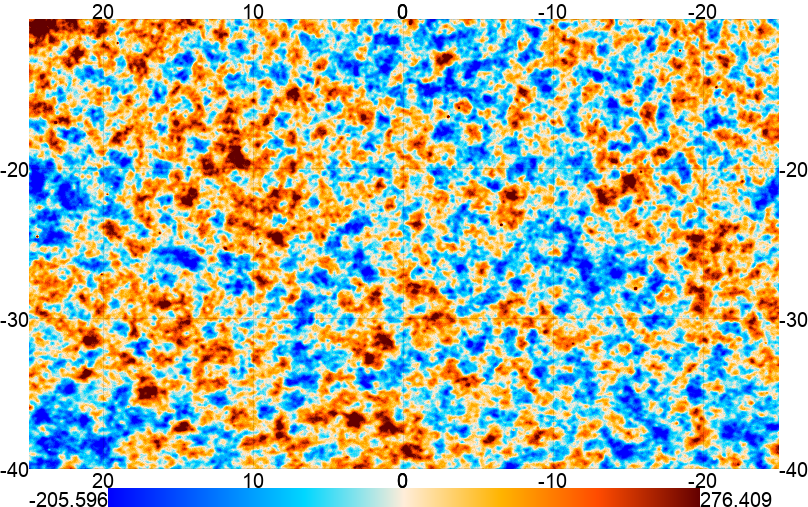

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


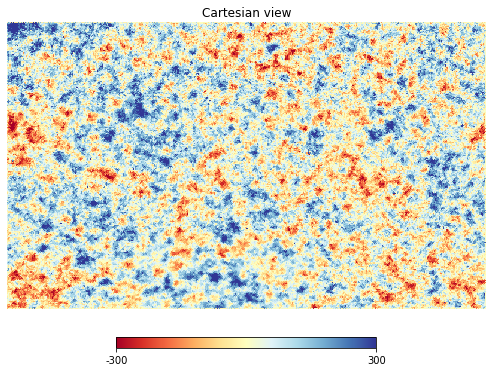

In [1]:
%run Section_3_HEALPix_CAR_Conversions.ipynb

# Harmonic analysis using CAR maps 

## Method 1:  Fourier transforms using Enmap

We will begin by trimming both ACT and Planck maps to the same size, and then we use enmap's functions to Fourier transform the map using the 'flat-sky' approximation.  

Before Fourier transforming the maps it is necessary to apodize the edges of the maps so that periodic boundary conditions apply.  This can easily be done using the enmap library of functions. The taper can be adjusted by changing the 'apod_pix' variable which adjusts the number of pixels that are apodized.

Here we chose to use only the I maps, however, the Q and U maps can of course be tapered in the same manner if desired.

Apodization


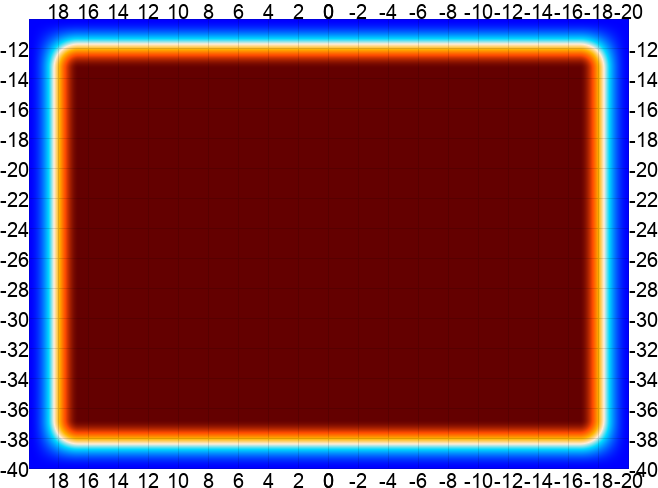

Apodized ACT map


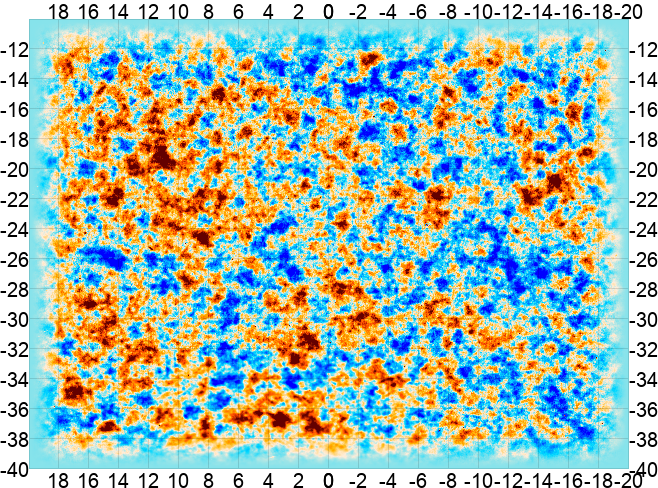

Apodized Plank map


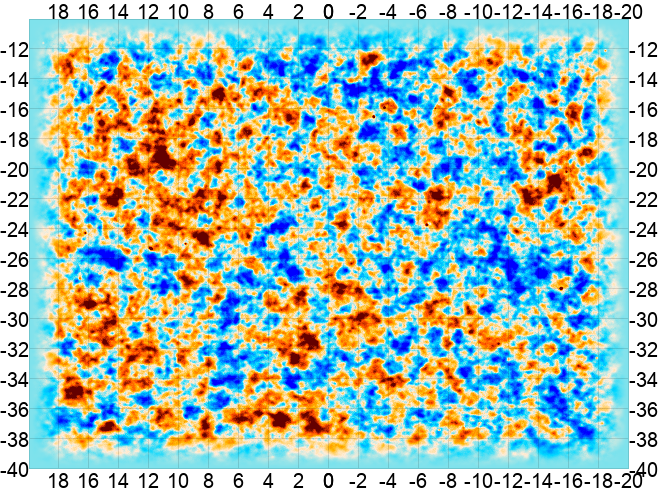

In [3]:
# Trim Maps
box = np.array([[-40,20],[-10,-20]])*utils.degree
smap_act    = imap.submap(box)
smap_planck = planck_map.submap(box)

# Define taper using enmap.apod and then plot the taper
apod_pix = 100
taper    = enmap.apod(smap_act*0+1,apod_pix) #Ensures the taper map has the same shape and wcs as the data
print("Apodization")
eshow(taper,  **{"downgrade": 2, "ticks": 2})

# Apply taper to the two maps by multiplying the taper and maps together
print("Apodized ACT map")
eshow(taper*smap_act, **{"downgrade": 2,  "ticks": 2})

print("Apodized Plank map")
eshow(taper*smap_planck[0], **{"downgrade": 2,  "ticks": 2})

Now that we have the apodized maps we can begin the harmonic analysis.  

Step one is to use enmap to get a Fourier transformation of the map.  For ease of use we set the normalization of the Fourier transformation to physical by passing the 'phys' parameter.  This makes Pixell take into account pixel area factors when calculating the power, and results in power spectra with steradians as the unit of area.

Once you have the Fourier transformed map it is possible to make a naive power spectra by multiplying by the conjugate of the Fourier transformed map and then binning the spectra.

One thing we note is that Pixell has a function that lets you call the 'modlmap' of a ndmap.  This is a map that gives the distance in Fourier space of each pixel to the center of the map.  It's particularly useful for binning the power spectra and we will use it in the binning function below.

In [4]:
# Fourier transform the map:
kmap_act = enmap.fft(smap_act*taper, normalize = 'phys')
kmap_planck = enmap.fft(smap_planck[0]*taper, normalize = 'phys')

# Get cross power
cross_power = abs(kmap_act*np.conj(kmap_planck))

# Define a function that can bin the power by Fourier component magnitude
# This is the flat sky equivalent of "ell"
def bin(data, imap, lmax, bin_size):
    modlmap = imap.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    binned = np.bincount(digitized, data.reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    return centers, binned

# The Taper we applied earlier effects the power spectrum. 
# Pixell doesn't have the capability to fully account for the taper
# But we can get an approximate correction by dividing out the following term
w2 = np.mean(taper**2)

ell_b, binned_cross_power = bin(cross_power/w2, smap_act, lmax = 6000, bin_size = 40)

Now that we've binned the power spectrum we made we can plot it quickly to have a look at it.

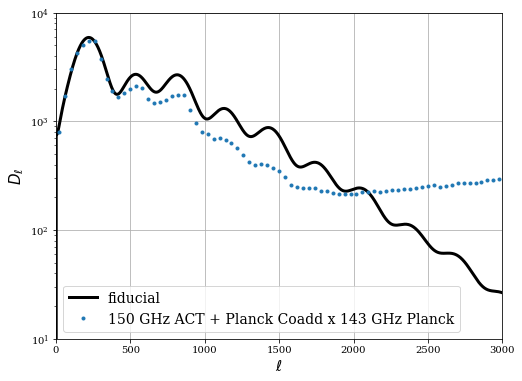

In [7]:
# Read in a camb fiducial spectrum for comparison
from pixell import powspec
camb_theory = powspec.read_spectrum(path + "camb_theory.dat")
cltt = camb_theory[0,0,:3000]
ls = np.arange(cltt.size)

# Now plot the quick powerspectrum we just made
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')

plt.plot(ls, cltt*ls**2./2/np.pi, lw=3, color='k', label = "fiducial")
plt.plot(ell_b, ell_b**2*binned_cross_power/2/np.pi, marker=".", ls="none",
         label = "150 GHz ACT + Planck Coadd x 143 GHz Planck")
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 15)
plt.ylabel('$D_{\\ell}$', fontsize = 15)
plt.xlim(0, 3000)
plt.ylim(10, 1e4)
plt.grid(True)
plt.legend(fontsize = 14)
plt.show()

We see two prominent features in this cross-spectrum: for intermediate $l$, there is some "missing" cross-power with respect to the fiducial curve. At high $l$, the data has a rising cross-power "tail," while the fiducial spectrum continues to fall off.

Generally speaking, the former feature is due to a combination of the damping effect of the various transfer functions in the experiments (e.g. Planck's wider beam), which we haven't accounted for. The latter captures the contribution from small-scale features in the maps, such as point sources and high-frequency noise. 

As a quick demonstration of the difference in the two experiments, we can plot the ACT-only power spectrum (i.e. the ACT autospectrum).

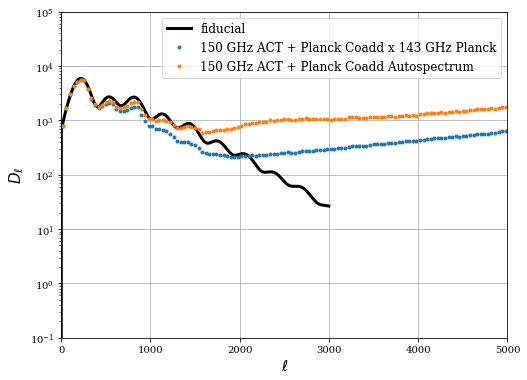

In [11]:
# Get ACT power
auto_power = abs(kmap_act*np.conj(kmap_act))

ell_b, binned_auto_power = bin(auto_power/w2, smap_act, lmax = 6000, bin_size = 40)

# Plot the ACT autospectrum
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')

plt.plot(ls, cltt*ls**2./2/np.pi, lw=3, color='k', label = "fiducial")
plt.plot(ell_b, ell_b**2*binned_cross_power/2/np.pi, marker=".", ls="none",
         label = "150 GHz ACT + Planck Coadd x 143 GHz Planck")
plt.plot(ell_b, ell_b**2*binned_auto_power/2/np.pi, marker=".", ls="none",
         label = "150 GHz ACT + Planck Coadd Autospectrum")
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 15)
plt.ylabel('$D_{\\ell}$', fontsize = 15)
plt.xlim(0, 5000)
plt.ylim(.1, 1e5)
plt.grid(True)
plt.legend(fontsize = 12)
plt.show()

As expected, we recover some of the intermediate $l$ power. On the other hand, we lose the benefit of having uncorrelated (really, less-correlated) noise between the two maps, so the power of the high $l$ tail has increased.

We should also recognize that this method vastly simplifies the power spectrum analysis pipeline because and we would normally generate ACT spectra using splits of the data instead of a single map auto-correlated with itself.

## Method 2: Spherical harmonics using Pixell

We turn now to Pixell's curvedsky functions that enable spherical harmonic analysis of the patches.  The process is very similar to what one would do using the HEALPix library.  

We will begin by calculating the alms from the maps; from there we can get the cls from the alms. Next we will again  weight our power spectrum by an area correction factor as well as the taper we've applied.

In [8]:
from pixell import curvedsky 

# First we get the alms
alms_act = np.cdouble(curvedsky.map2alm(smap_act*taper, lmax = 6000))
alms_planck = np.cdouble(curvedsky.map2alm(smap_planck*taper, lmax = 6000)[0])

# Next we get the cls using healpy
cls = hp.alm2cl(alms_act, alms_planck)

# We also want the corresponding ells which we can get easily
ell = np.arange(len(cls))

# Now we calculate the weighting we have to apply to our spectrum due to the 
# trimmed size
w2_new = enmap.area(smap_act.shape, smap_act.wcs)/4./np.pi

# Now we combine these to get the Dls
Dl = cls*ell**2 /2/np.pi/ w2_new 

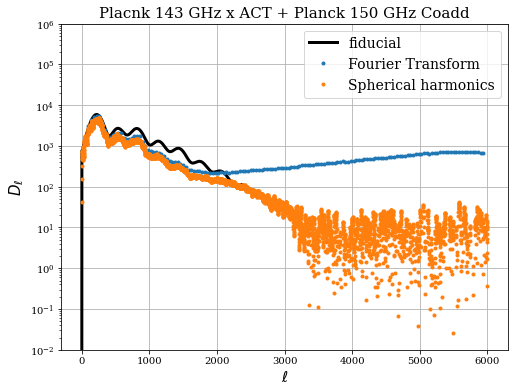

In [9]:
# Now we can plot our power spectrum
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.grid(True)
plt.plot(ls,cltt*ls**2./2/np.pi,lw=3,color='k', label = "fiducial")
plt.plot(ell_b,ell_b**2*binned_cross_power/2/np.pi,marker=".",ls="none", label = "Fourier Transform")
plt.plot(ell, Dl, '.', label = "Spherical harmonics")
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize = 15)
plt.ylabel('$D_{\\ell}$', fontsize = 15)
plt.title("Placnk 143 GHz x ACT + Planck 150 GHz Coadd", fontsize = 15)
plt.ylim(.01 ,1e6)
plt.legend(fontsize = 14)
plt.show()

In the plot above we can quite clearly see some of the acoustic oscillations as we would expect, and the agreement with the fiducial spectrum has improved versus the flat sky approximation at high $l$. However, there are still a few glaring problems.  Firstly, the spectrum  hasn't been corrected for beams or other pixel transfer functions both of which would need to be done for a true analysis.  This effect is easily noticeable at intermediate $l$ where our power spectra underestimates the fiducial spectrum. Also, we didn't mask point sources which can be done using the correct Planck mask and the source free ACT maps (the spectrum still plateaus at high $l$).

Furthermore we account for the window function using a relatively simple approach, however, to truly decouple it one should use a program such as **Namaster**, **pspy** or **pitas** which explicitly decouple the window functions.  We will look at [Nawrapper](https://github.com/xzackli/nawrapper), a light wrapper for **Namaster** which was designed for CMB, and particularly ACT, work.

Finally it's important to realize that calculating the error for any cross correlations would need to include knowledge of the noise model which is currently not complete.  

Despite the limitations, quick and useful power spectra can be made relatively easily using this approach and can be done with galaxy density maps or other CMB maps.

### Continue to the next section

[Section 8](Section_8_power_spectra_part_2.ipynb): Power Spectra Part 2 - Individual Map splits and Nawrapper [Aiola et al] and [Choi et al] 
